# **Top Highlights  📌**


---

1. Exploring `Self-Attention` and `MultiHead-Attention` with **visualizations**.

2. Design of a **robust** and **easy-to-use** text preprocessing **pipeline**. 

3. Usage of `Dask` for **multiprocessing** jobs in **accelerating** `Pandas` operations.

4. Fine-tune `BERT` on **two** tasks (data with light preprocesing and data with heavy preprocessing) and comparing the results.

5. Comparing `BERT` and `XLNet`

---





# **Assignment Layout 📎**



---


1. **Visualizations:** Understanding Self-Attention with visualizations.

2. **Exploring the Data:** We will look at many different examples in the dataset, calculate some useful statistics.

3. **Design of Text Preprocessing Pipeline:** Once we have completed the exploration of our dataset, we will implement the processing pipeline. 

4. **Fine-Tuning BERT** We will fine-tune BERT on two tasks, one with light preprocessing and the other with heavy preprocessing, to understand the model better. 

5. **Fine-Tuning XLNet:** We will fine-tune XLNet.

6. **Conclusions:** We will compare the results for the different models and present conclusions


---



In [ ]:
!sudo apt install openjdk-8-
!sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!pip install -q emoji
!pip install -q ktrain
!pip install -q wordsegment
!pip install -q autocorrect
!pip install -q transformers
!pip install modin[ray]
!pip install symspellpy

In [ ]:
!nvidia-smi

Mon Sep  7 08:36:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
#import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import numpy as np
import math
import textwrap
import emoji
import spacy
import pkg_resources
nlp = spacy.load('en_core_web_sm')

from wordsegment import load, segment
load()
from gensim.parsing.preprocessing import remove_stopwords
from tqdm.notebook import tqdm
from autocorrect import Speller
from symspellpy import SymSpell, Verbosity
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
spell = Speller()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Visualizing Self-Attention 💡**


---

* `Self-Attention` in simple words, is the exact same thing as `Attention`, but applied to the inputs of the **same** layer rather than the **previous** layer as in `Bahdanau Attention` we saw in one of the previous assignments.

* Modern NLP beasts like `BERT`, `GPT-2`, `XLNet` are all based on the common `Transformer` architecture which is based entirely on `Self-Attention` layers in the Encoder and/or Decoder.

* In this section, we have used a visualization tool created by [Jesse Vig](https://github.com/jessevig/bertviz) to discern some of the `Self-Attention` patterns of BERT.



---






In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1074, done.
remote: Total 1074 (delta 0), reused 0 (delta 0), pack-reused 1074
Receiving objects: 100% (1074/1074), 99.41 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [ ]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

sentence_a = "The rabbit quickly hopped"
sentence_b = "The turtle slowly crawled"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence_a = "Who is Sherlock Holmes?"
sentence_b = "He is a world-famous fictional detective"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Obeservations**


---

1. In the first example, we see that one of the `Attention Heads` shows us how BERT is able to capture semantically similar words such as: 

  * Rabbit -> Hopped 
  * Crawled -> Turtle

2. In the second example, we see that one of the `Attention Heads` looks at words like "sherlock", "holmes", "detective", "famous" when we point at "he". 

3. We also see that another `Attention Head` captures some extra information when pointing at the word "detective" which is missed by the previous `Attention Head`.

4. This shows how different heads capture and compensate each other and why `MultiHeaded-Attention` is important! 


---







## **Dataset Exploration 🧭**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# read in the dataset
df = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/train.csv', header=None)
df.columns = ['Sentiment', 'Reviews']
df['Sentiment'] = df.Sentiment.apply(lambda x: 1 if x == 2 else 0)
df.head()

,Sentiment,Reviews
0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...


In [ ]:
# define a sampling utility function
def sample(df, example_number, width=50):
  print(textwrap.fill(df['Reviews'][example_number], width=width))
  print("\n\nSENTIMENT LABEL: {}".format(df['Sentiment'][example_number]))

# lets pull out some examples to see the structure of each sentence
example_number = 13124
sample(df, example_number=example_number, width=50)

Bought a Groupon and used #1 of 3.  Not sure I
will go back to use the other 2. The food was not
good at all. Ordered a cheeseburger, potato salad
another bacon cheeseburger and Hawaiian coleslaw.
To drink we ordered a chocolate malt and a
strawberry shake. The cheeseburgers were frozen
patties and cooked clean into next week. Dry
hockey pucks. The potato salad was ok the Hawaiian
coleslaw was very blah.. The shake and malt were
delicious even though they were not delivered
until our burgers were finished. The waitstaff was
like the walking dead, they had not an ounce of
enthusiasm. When we sat down not one person
acknowledged we were there. Waitress was not
friendly either. No French fries!!! Potato salad,
chips, coleslaw, carrot raisin salad. Wow! This
place could be a goldmine, how about a friendly
staff, and pattied burgers and if you can't have a
deep fryer, how about some American Fries made
from good old boiled potatoes. Put it this way,
you get out of the place what you put int

#### **Observations**


---


1.   Presence of next line character `\n`.

2.   Non-uniform whitespaces.

3.   Brackets `(..)`

4.   Hyphens `-` and special characters like hashtags `#` 

5.   Several reviews have the `$` character, but we want to keep it because it holds key information for the model. 

6.   Period characters like `. . .` are also present

7.   Punctuations and numbers. Numbers we want to keep, punctuations not so much.

8.   Typos
---









### **Class Distribution**

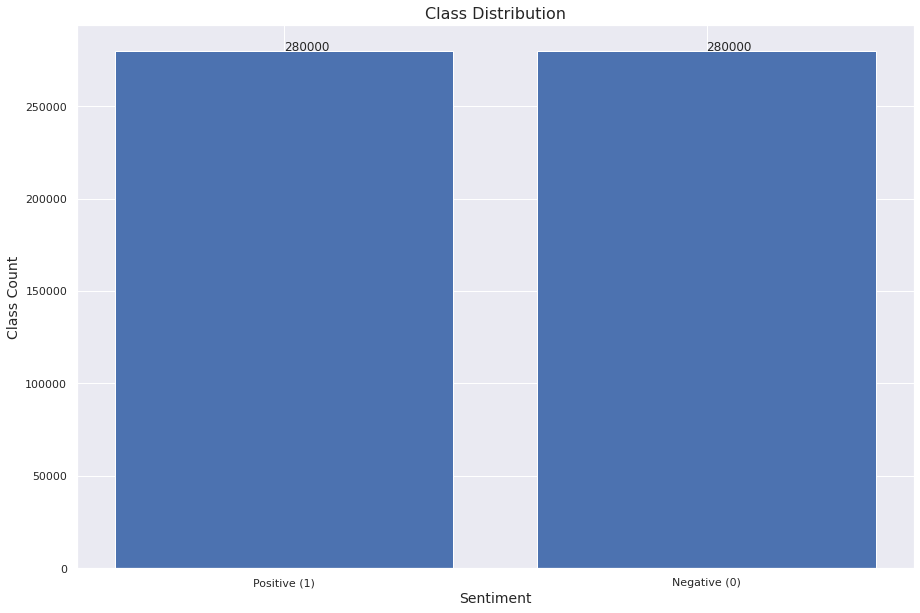

In [ ]:
# plot class distribution
sns.set()
df_copy = df.copy()
counts = df_copy['Sentiment'].value_counts().tolist()
sentiments = ['Positive (1)', 'Negative (0)']
plt.figure(figsize=(15, 10))
plt.title("Class Distribution", fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel("Class Count", fontsize=14)
plt.bar(sentiments, counts)
for i in range(len(sentiments)):
  plt.annotate(str(counts[i]), xy=(sentiments[i], counts[i]))
plt.show()

### **Average length of reviews**

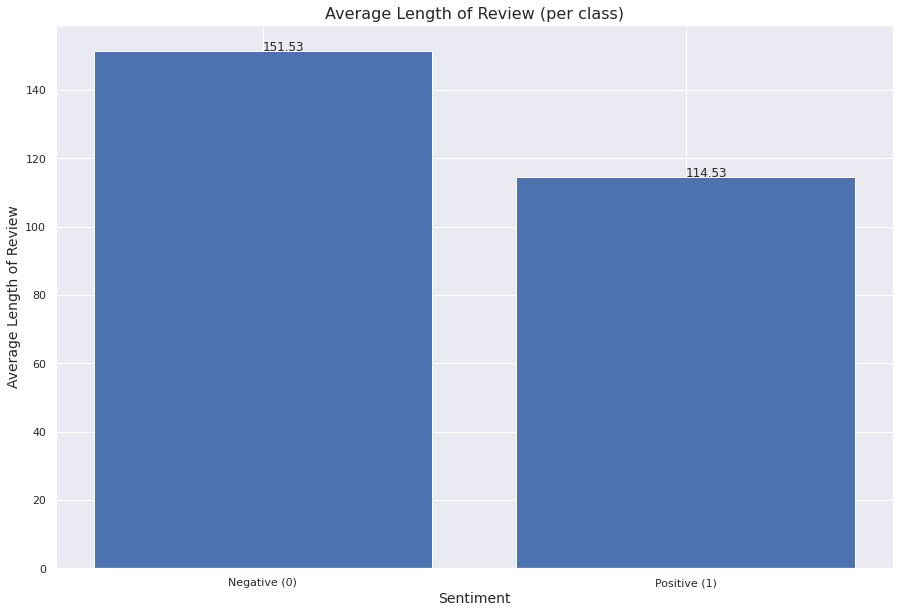

Overall Average length is: 132.56


In [ ]:
# plot average length of reivews per class
def plot_average_lengths(df):
  df_copy = df.copy()
  df_copy['Length of Review'] = df_copy.apply(lambda x: len(x['Reviews'].split()), axis=1)
  avg_length = sum(df_copy.groupby('Sentiment')['Length of Review'].sum().tolist()) / sum(df_copy['Sentiment'].value_counts().tolist())
  avg_length_per_class = [x / df_copy['Sentiment'].value_counts().tolist()[-1] for x in df_copy.groupby('Sentiment')['Length of Review'].sum().tolist()]
  sentiments = ['Negative (0)', 'Positive (1)']
  plt.figure(figsize=(15, 10))
  plt.title("Average Length of Review (per class)", fontsize=16)
  plt.xlabel('Sentiment', fontsize=14)
  plt.ylabel("Average Length of Review", fontsize=14)
  plt.bar(sentiments, avg_length_per_class)
  for i in range(len(sentiments)):
    plt.annotate(str(round(avg_length_per_class[i], 2)), xy=(sentiments[i], avg_length_per_class[i]))
  plt.show()

plot_average_lengths(df)
print('Overall Average length is: {}'.format(round(avg_length, 2)))

#### **Observations**


---


1.   We notice that on average, positive reviews are shorter by **~38** words than negative reviews which we can hypotheise as angry customers tend to rant out or take a bit more effort to cite their poor experience.

2.   It also important to note that these lengths have been calculated on string splits based on whitespaces and next line characters. 

3.   The length may be slightly different when using a different tokenization strategy (such as subword tokenization of BERT and XLNet) but the average overall difference should stay more or less the same. 



---







### **Building a "dumb" classifier**

---

*   We can use these observations and test our hypothesis by creating a "dumb" classifier that assigns a positive or negative sentiment to the review based solely on the length of the review alone. 

*   We can use this classifier as a basline to gauge the performance of the ML models we develop later on.

---






In [ ]:
# read in the test dataset
df_test = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/test.csv', header=None)
df_test.columns = ['Sentiment', 'Reviews']
df_test['Sentiment'] = df_test.Sentiment.apply(lambda x: 1 if x == 2 else 0)
df_test.head()

,Sentiment,Reviews
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


In [ ]:
# create a simple classifier
df_test['Predicted'] =  df_test.apply(lambda x: 0 if len(x['Reviews'].split()) > 115  else 1, axis = 1)

# calculate accuracy
accuracy = sum(df_test.apply(lambda x: 1 if x['Sentiment'] == x['Predicted']  else 0, axis = 1).tolist()) / len(df_test)

# display accuracy
print('Accuracy of dumb classifer: {}'.format(round(accuracy * 100, 2)))

Accuracy of dumb classifer: 56.41


#### **Observations**


---


1.   When we use the average length insight for building a classifier, we do slightly better than random guessing at **56.41%**

2.   We can manually try screening for "negative" and "positive" words in the dataset and use those to boost the accuracy of the classifier but the manual effort involved is obviously huge and even then, this has many drawbacks.

3.   This actually just shows us how powerful ML really is. 

---






## **Next Steps: The Text Processing Pipeline 🔧**

Moving forward, we now need to build our text processing pipeline which will take care of cleaning the data. 

---

The following steps are performed:


*   Remove any HTML artifacts. 

*   Handle hastags, mentions, emojis or punctuations like `(. . .)`, `-` and `\n`, since they add little or no information. We retain exclaimation marks and question marks.

*   Handle basic typos or spelling mistakes.

*   Handle non-uniform spacing and informal language like `goooood` or `veryyy bad`.

*   Break up words like "NotAGoodProduct" into "not a good product". 

*   Remove Stop-Words and perform Lemmatization.



We have added some more generic cleaning procedures (like emojis) in addition to our original set of observations to take care of future data which may contain such cases. 



---








### **Defining a Text Preprocessing Pipeline**

In [ ]:
class PreprocessingPipeline():
  """
  A utility class which defines a generalized, robust and flexible text processing pipeline. 
  If steps are not passed in, all steps will be applied by default. 
  """

  def __init__(self, **kwargs):
    self.html_and_urls = kwargs.get('html_and_urls', True)
    self.emojis_and_punctuation = kwargs.get('emojis_and_punctuation', True)
    self.spellcheck = kwargs.get('spellcheck', True)
    self.hashtags = kwargs.get('hastags', True)
    self.stop_words = kwargs.get('stop_words', True)
    self.lemmatization = kwargs.get('lemmatization', True)

    self.available_steps = ['html_and_urls', 
                       'emojis_and_punctuation', 
                       'spellcheck', 
                       'hashtags',
                       'stop_words',
                       'lemmatization']

    # create pipeline queing the requested steps
    self.pipeline_steps = [step for step in self.available_steps if getattr(self, step) == True]
    print('The following transforms will be applied:\n {}'.format(self.pipeline_steps))
  

  # 1. Remove HTML and web URL artifacts
  def process_html_and_urls(self, text):
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', ' ', text, flags=re.MULTILINE) 
    text = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', ' ', text, flags=re.MULTILINE) 
    return text

  # 2. Remove Emojis, New line characters and Punctuations
  def process_emojis_and_punctuation(self, text):
      text = emoji.get_emoji_regexp().sub(u' ', text)
      text = re.sub(r'[-+\[\](){};:@\+<>\^&\*_~]|(\\n)|(!+(?=.*\!))', '', text)
      text = re.sub(r'\.{2,}', '', text)
      text = re.sub(r' +', ' ', text)       
      return text

  # 3. Correct typos
  def process_spellcheck(self, text):
      return spell(text)

  # 4. Remove Mentions, Hashtages and normalize
  def process_hashtags(self, text):
    for match in re.findall(r'(#[A-Za-z]+)', text): 
      text = text.replace(match, ' '.join(segment(match)))
    return text

  # 5. Remove stop words
  def process_stop_words(self, text):
    return remove_stopwords(text)

  # 6. Lemmetizations
  def process_lemmatization(self, text):
    doc = nlp(text)
    lemma = ' '.join([w.lemma_ if w.lemma_ != '-PRON-' else w.text for w in doc])
    text = re.sub(r'\s([?,.!"](?:\s|$))', r'\1', lemma).lower()
    return text.translate(str.maketrans('', '', string.punctuation))

  # execute pipeline using requested steps
  def execute_pipeline(self, text):
    self.text = text
    for step in self.pipeline_steps:
      self.text = getattr(self, f'process_{step}')(self.text)
    return self.text

In [ ]:
# define a test case
text = df_test['Reviews'][0] + ' www.google.com/tensorflow' + ' ' + 'https://colab.research.com' + ' #ILoveColab #MumbaiRocks @Google Recomeded'

# print out the test text
print("UNPROCESSED TEXT:\n\n{}".format(textwrap.fill(text)))

UNPROCESSED TEXT:

Contrary to other reviews, I have zero complaints about the service or
the prices. I have been getting tire service here for the past 5 years
now, and compared to my experience with places like Pep Boys, these
guys are experienced and know what they're doing. \nAlso, this is one
place that I do not feel like I am being taken advantage of, just
because of my gender. Other auto mechanics have been notorious for
capitalizing on my ignorance of cars, and have sucked my bank account
dry. But here, my service and road coverage has all been well
explained - and let up to me to decide. \nAnd they just renovated the
waiting room. It looks a lot better than it did in previous years.
www.google.com/tensorflow https://colab.research.com #ILoveColab
#MumbaiRocks @Google Recomeded


In [ ]:
# instatiate the pipeline with defaults
pipeline = PreprocessingPipeline()

The following transforms will be applied:
 ['html_and_urls', 'emojis_and_punctuation', 'spellcheck', 'hashtags', 'stop_words', 'lemmatization']


In [ ]:
# execute the requested steps
cleaned_text = pipeline.execute_pipeline(text)

# print the results to console
print("CLEANED TEXT:\n\n{}".format(textwrap.fill(cleaned_text)))

CLEANED TEXT:

contrary review i zero complaint service price i get tire service past
5 year now compare experience place like zep boys guy experience know
they be do also place i feel like i take advantage of gender other
auto mechanic notorious capitalizing ignorance car suck bank account
dry but here service road coverage explain let decide and renovate
wait room it look lot well previous year love colab mumbai rock google
recommended


#### **Just some unit tests**

In [ ]:
text = pipeline.process_html_and_urls(text)
print(textwrap.fill(text))

Contrary to other reviews, I have zero complaints about the service or
the prices. I have been getting tire service here for the past 5 years
now, and compared to my experience with places like Pep Boys, these
guys are experienced and know what they're doing. \nAlso, this is one
place that I do not feel like I am being taken advantage of, just
because of my gender. Other auto mechanics have been notorious for
capitalizing on my ignorance of cars, and have sucked my bank account
dry. But here, my service and road coverage has all been well
explained - and let up to me to decide. \nAnd they just renovated the
waiting room. It looks a lot better than it did in previous years.
#ILoveColab #MumbaiRocks @Google Recomeded


In [ ]:
text = pipeline.process_emojis_and_punctuation(text)
print(textwrap.fill(text))

Contrary to other reviews, I have zero complaints about the service or
the prices. I have been getting tire service here for the past 5 years
now, and compared to my experience with places like Pep Boys, these
guys are experienced and know what they're doing. Also, this is one
place that I do not feel like I am being taken advantage of, just
because of my gender. Other auto mechanics have been notorious for
capitalizing on my ignorance of cars, and have sucked my bank account
dry. But here, my service and road coverage has all been well
explained and let up to me to decide. And they just renovated the
waiting room. It looks a lot better than it did in previous years.
#ILoveColab #MumbaiRocks Google Recomeded


In [ ]:
text = pipeline.process_spellcheck(text)
print(textwrap.fill(text))

Contrary to other reviews, I have zero complaints about the service or
the prices. I have been getting tire service here for the past 5 years
now, and compared to my experience with places like Zep Boys, these
guys are experienced and know what they're doing. Also, this is one
place that I do not feel like I am being taken advantage of, just
because of my gender. Other auto mechanics have been notorious for
capitalizing on my ignorance of cars, and have sucked my bank account
dry. But here, my service and road coverage has all been well
explained and let up to me to decide. And they just renovated the
waiting room. It looks a lot better than it did in previous years.
#ILoveColab #MumbaiRocks Google Recommended


In [ ]:
text = pipeline.process_hashtags(text)
print(textwrap.fill(text))

Contrary to other reviews, I have zero complaints about the service or
the prices. I have been getting tire service here for the past 5 years
now, and compared to my experience with places like Zep Boys, these
guys are experienced and know what they're doing. Also, this is one
place that I do not feel like I am being taken advantage of, just
because of my gender. Other auto mechanics have been notorious for
capitalizing on my ignorance of cars, and have sucked my bank account
dry. But here, my service and road coverage has all been well
explained and let up to me to decide. And they just renovated the
waiting room. It looks a lot better than it did in previous years. i
love colab mumbai rocks Google Recommended


In [ ]:
text = pipeline.process_stop_words(text)
print(textwrap.fill(text))

Contrary reviews, I zero complaints service prices. I getting tire
service past 5 years now, compared experience places like Zep Boys,
guys experienced know they're doing. Also, place I feel like I taken
advantage of, gender. Other auto mechanics notorious capitalizing
ignorance cars, sucked bank account dry. But here, service road
coverage explained let decide. And renovated waiting room. It looks
lot better previous years. love colab mumbai rocks Google Recommended


In [ ]:
text = pipeline.process_lemmatization(text)
print(textwrap.fill(text))

contrary review i zero complaint service price i get tire service past
5 year now compare experience place like zep boys guy experience know
they be do also place i feel like i take advantage of gender other
auto mechanic notorious capitalizing ignorance car suck bank account
dry but here service road coverage explain let decide and renovate
wait room it look lot well previous year love colab mumbai rock google
recommended


### **What do BERT and XLNet bring to the table?**


---


*   One feature common between the two models (and other pretrained transformer models) is that they bring with them their own tokenizers and learnt embeddings (pretrained weights).

*   We could use our own tokenizer, but it does not make any sense to use a different tokenizer (with different tokenizing rules and vocabulary) than the tokenizer with which the model was trained. 

*   We could also keep the model's native tokenizer, but use pretrained embeddings such as `word2vec` or `gLOve` or `FastText` but since BERT and XLNet both use subword tokenizers, embeddings for all the tokens will not be present with us and the ones we assign might not be as accurate as the ones the model (trained on a collasal corpus) has generated.


*   In conclusion, it makes sense to use the native tokenizer recommended by the model which works with the pretrained weights perfectly instead of trying to touch that part of the pipeline.


---








## **BERT 🚀**


---

* We'll use [huggingface's Transformers library](https://huggingface.co/transformers/index.htmlhuggingface.co) in TensorFlow to fine-tune BERT on the classification task.

* Specifically, we'll train BERT on two tasks:

  1. Task 1: Free English (stop words and lemmatization NOT performed)
  
  2. Task 2: Stop-Words-Removed + Lemmatized data

* We'll then compare the performance of both the models to get better insights about the Model. 


---





### **Task 1: Training on Free English**

---

* The reviews include all the processing steps defined in the pipeline with the exception of Stop-Words-Removal and Lemmatization.

* The idea is to keep the language free-flowing and more human-like as opposed to a heavily processed one and gauge the performance of the model. 


---




#### **Load BERT Model**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Dummy Processing Code (Using Dask)**


---

* Applying the transformation (preprocessing) function to all the reviews (0.6M) in the dataset takes an **estimated time of more 3-4 hours.**

* We need to **parallelize** this computation. 

* This can be done by taking advantage of **multi-CPU infrastructure** of our machine using **Dask engine** under the hood.

* Dask **splits the DataFrame into partitions** on which computation runs **in parallel across cores/threads on the machine.** 

* **Using Dask, the computation time is reduced to less than 7 minutes!**

---

*NOTE: The code that has been pasted here was run on author's local machine which supported 8 threads. Colab only supports a single thread and hence the enclosed code cells must not be executed in Colab.*





In [ ]:
import multiprocessing
import dask.dataframe as dd

In [ ]:
# read in the dataset
df = pd.read_csv(
        '/Users/bhargavdesai/Downloads/yelp_review_polarity_csv/train.csv', header=None)
df.columns = ['Sentiment', 'Reviews']
df['Sentiment'] = df.Sentiment.apply(lambda x: 1 if x == 2 else 0)
df.head()

# instatiate the pipeline with defaults
pipeline = PreprocessingPipeline(spellcheck=False)

# use dask engine to parallelize computation
start = time.time()
df['Clean Reviews'] = dd.from_pandas(df, npartitions=multiprocessing.cpu_count()).map_partitions(lambda y: y.Reviews.apply(
        lambda x: pipeline.execute_pipeline(x))).compute(scheduler='processes')
end = time.time()
print(end - start)
df.to_csv(
        '/Users/bhargavdesai/Desktop/Quantiphi/test_stopwords_and_lemma-*.csv', index=False)

In [ ]:
print(textwrap.fill(df_copy['Cleaned Reviews'][0]))

unfortunately frustration dr goldberg s patient repeat experience i
have doctor nyc good doctor terrible staff it staff simply answer
phone it usually take 2 hour repeat call answer who time want deal it
i run problem doctor i do not it you office worker patient medical
need be not answer phone it be incomprehensible work aggravation it be
regret i feel i dr goldberg 2 star


#### **Load Processed Data (from Local)**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/free_english.csv').drop('Unnamed: 0', axis=1)

In [ ]:
df.head()

,Sentiment,Reviews,Clean Reviews
0,0,"Unfortunately, the frustration of being Dr. Go...","Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...,All the food is great here. But the best thing...


#### **Decide Truncation Threshold for the Reviews**



---



In [ ]:
# Max lengths (for deciding max lengths)
import time
import statistics
start = time.time()

x = tokenizer(df['Clean Reviews'].tolist(), add_special_tokens=False, truncation=True)
lengths = [len(tokenize_sent) for tokenize_sent in x['input_ids']]

end = time.time()
print("Average Length: {:3f}, Std. Deviation: {:.2f}, Time Taken: {:2f}".format(statistics.mean(lengths), statistics.stdev(lengths), end - start))

Average Length: 167.634787, Std. Deviation: 132.97, Time Taken: 1200.1628472805023


#### **Model Fine-Tuning**

In [ ]:
# train on reduced dataset (for faster iteration time)
retention_factor = 0.5
total_data = len(df)

# tokenize the text according to BERT
df_train = df[:math.floor(retention_factor * total_data)]
x = tokenizer(df_train['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_train['Sentiment'].tolist()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
# set callback to end training after 2 hours
timed_callback = tfa.callbacks.TimeStopping(
    seconds= 100,
    verbose= 1
)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(200000).batch(4), epochs=1, callbacks = [timed_callback])

Epoch 1/10
 1002/69999 [..............................] - ETA: 8:41:55 - loss: 0.2994 - accuracy: 0.8733

KeyboardInterrupt: ignored

#### **Testing**

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/test_processed-*.csv')

In [ ]:
# tokenize the text according to BERT
x = tokenizer(df_test['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_test['Sentiment'].tolist()

In [ ]:
eval_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
model.evaluate(eval_dataset.shuffle(100000).batch(4))

9500/9500 [==============================] - 1470s 155ms/step - loss: 0.1739 - accuracy: 0.9327


[0.17392079532146454, 0.9326841831207275]

#### **Saving and Loading**

In [ ]:
model.save('/content/drive/My Drive/yelp_review_polarity_csv/BERT_free_english', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/yelp_review_polarity_csv/BERT_free_english/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/yelp_review_polarity_csv/BERT_free_english')

### **Task 2: Training on (Stop Words Removed + Lemmatized) Data**



---

* In Task 2, we perform all the steps of the defined pipeline INCLUDING Stop-Word-Removal and Lemmatization

* The idea is to see how the model does when the text is not free-flowing English anymore. It gives us an idea about what the model prefers as input.

---



#### **Load BERT Model**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Dummy Processing Code (Using Dask)**


---

* Applying the transformation (preprocessing) function to all the reviews (0.6M) in the dataset takes an **estimated time of more 3-4 hours.**

* We need to **parallelize** this computation. 

* This can be done by taking advantage of **multi-CPU infrastructure** of our machine using **Dask engine** under the hood.

* Dask **splits the DataFrame into partitions** on which computation runs **in parallel across cores/threads on the machine.** 

* **Using Dask, the computation time is reduced to less than 7 minutes!**

---

*NOTE: The code that has been pasted here was run on author's local machine which supported 8 threads. Colab only supports a single thread and hence the enclosed code cells must not be executed in Colab.*





In [ ]:
import multiprocessing
import dask.dataframe as dd

In [ ]:
# read in the dataset
df = pd.read_csv(
        '/Users/bhargavdesai/Downloads/yelp_review_polarity_csv/train.csv', header=None)
df.columns = ['Sentiment', 'Reviews']
df['Sentiment'] = df.Sentiment.apply(lambda x: 1 if x == 2 else 0)
df.head()

# instatiate the pipeline with defaults
pipeline = PreprocessingPipeline(spellcheck=False)

# use dask engine to parallelize computation
start = time.time()
df['Clean Reviews'] = dd.from_pandas(df, npartitions=multiprocessing.cpu_count()).map_partitions(lambda y: y.Reviews.apply(
        lambda x: pipeline.execute_pipeline(x))).compute(scheduler='processes')
end = time.time()
print(end - start)
df.to_csv(
        '/Users/bhargavdesai/Desktop/Quantiphi/test_stopwords_and_lemma-*.csv', index=False)

#### **Load Processed Data (from Local)**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/train_stopwords_and_lemma_no_nans.csv')

In [ ]:
df.head()

,Sentiment,Reviews,Clean Reviews
0,0,"Unfortunately, the frustration of being Dr. Go...",unfortunately frustration dr goldberg s patien...
1,1,Been going to Dr. Goldberg for over 10 years. ...,be go dr goldberg 10 year i think i 1st patien...
2,0,I don't know what Dr. Goldberg was like before...,i do not know dr goldberg like move arizona le...
3,0,I'm writing this review to give you a heads up...,i be write review head doctor the office staff...
4,1,All the food is great here. But the best thing...,all food great here but good thing wing their ...


#### **Model Fine-Tuning**

In [ ]:
# train on reduced dataset (for faster iteration time)
retention_factor = 0.5
total_data = len(df)

# tokenize the text according to BERT
df_train = df[:math.floor(retention_factor * total_data)]
x = tokenizer(df_train['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_train['Sentiment'].tolist()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
# set callback to end training after 2 hours
timed_callback = tfa.callbacks.TimeStopping(
    seconds= 7200,
    verbose= 0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(200000).batch(4), epochs=1, callbacks = [timed_callback])

 1205/69996 [..............................] - ETA: 8:36:25 - loss: 0.3550 - accuracy: 0.8398

KeyboardInterrupt: ignored

#### **Testing**

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/test_stopwords_and_lemma_no_nans.csv')

In [ ]:
# tokenize the text according to BERT
x = tokenizer(df_test['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_test['Sentiment'].tolist()

In [ ]:
eval_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
model.evaluate(eval_dataset.shuffle(100000).batch(4))

9500/9500 [==============================] - 1465s 154ms/step - loss: 0.2661 - accuracy: 0.8936


[0.26614445447921753, 0.8936495184898376]

#### **Saving and Loading**

In [ ]:
model.save('/content/drive/My Drive/yelp_review_polarity_csv/BERT_stop_lemma', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/yelp_review_polarity_csv/BERT_stop_lemma/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/yelp_review_polarity_csv/BERT_stop_lemma')

## **XLNet 🚀**


---

* We'll follow the same procedure for XLNet as we did for BERT. 
* However, we will only be training it on Task 1.

---




### **Task 1: Training on Free English**

#### **Load XLNet Model**

In [ ]:
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:211: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification

#### **Load Processed Data (from Local)**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/train_processed-*.csv')

In [ ]:
df.head()

,Sentiment,Reviews,Clean Reviews
0,0,"Unfortunately, the frustration of being Dr. Go...","Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...,All the food is great here. But the best thing...


#### **Model Fine-Tuning**

In [ ]:
# train on reduced dataset (for faster iteration time)
retention_factor = 0.5
total_data = len(df)

# tokenize the text according to XLNet
df_train = df[:math.floor(retention_factor * total_data)]
x = tokenizer(df_train['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_train['Sentiment'].tolist()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
# set callback to end training after 2 hours
timed_callback = tfa.callbacks.TimeStopping(
    seconds= 100,
    verbose= 1
)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_dataset.shuffle(200000).batch(4), epochs=1, callbacks = [timed_callback])

 1012/69999 [..............................] - ETA: 17:47:23 - loss: 0.2723 - accuracy: 0.8901

KeyboardInterrupt: ignored

#### **Testing**

In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/yelp_review_polarity_csv/test_processed-*.csv')

In [ ]:
# tokenize the text according to XLNet
x = tokenizer(df_test['Clean Reviews'].tolist(), add_special_tokens=True, max_length=450, truncation=True, padding= 'max_length')
y = df_test['Sentiment'].tolist()

In [ ]:
eval_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x),
    y
))

In [ ]:
model.evaluate(eval_dataset.shuffle(100000).batch(4))

9500/9500 [==============================] - 2492s 262ms/step - loss: 0.2155 - accuracy: 0.9339


[0.2155332714319229, 0.9338947534561157]

#### **Saving and Loading**

In [ ]:
model.save('/content/drive/My Drive/yelp_review_polarity_csv/XLNet_free_english', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/yelp_review_polarity_csv/XLNet_free_english/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/yelp_review_polarity_csv/XLNet_free_english')

## **Conclusions ⚖️**


---

**Task 1 v. Task 2:**

1. `BERT` when trained on **lemmatized and stop-words-removed text** (Task 2) performed a lot **worse** than when trained on text **without** such preprocessing (Task 1). 

2. Of course, if given enough training time, models trained on both versions of the text would perform equally well since `BERT` is a very strong model, both in its design and pretraining philosophy. 

3. However, we do notice that `BERT` reaches **significantly higher train and test accuracies** with text that is not stop-words-removed or lemmatized. 

4. This can be attributed to the fact that **`BERT` was pretrained with full sentences** and hence does naturally better on full sentences in text.

**BERT v. XLNet:**

1. Both the models are powerhouses, however XLNet learns faster than BERT since it achieves a higher train accuracy (89%) as compared to BERT (87%) when trained for the same number of batches.

2. However, the test accuracies are more or less the same. But we do wager that XLNet might converge faster and perform better overall due to it's improved pretraining objective over the former.

**Multiprocessing using Dask:**

1. Without `Dask` and it's out-of-the-box multiprocessing support for `Pandas DataFrame`, a lot of time would have been wasted in just preparing the data. 

2. Other frameworks to speed up `Pandas` such as `Modin` was also explored however `Dask` performed much better. 
---


